In [1]:
import sys
sys.path.append('../')

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np

from src.models.net import *
from src.si import *
from src.util import util as ut

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/gmiglior/.conda/envs/stochint/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = UNet(
        dim = 64,
        dim_mults = (1,2,4,),
        flash_attn = True,
        channels=1,
        resnet_block_groups=4,
        attn_dim_head=32,
        attn_heads=4,
    )

model.load_state_dict(torch.load('../finetuning_scripts/celeba_model_lin/epoch_100.pt'))

<All keys matched successfully>

In [5]:
celeba = ut.celeba_dataset()


Files already downloaded and verified


In [6]:
# x_initial = torch.cat([img for (i, [img, _]) in enumerate(celeba) if i < 100 ], dim=0)

x_initial = []
for i, [img, _] in enumerate(celeba):
    if i == 10:
        break
    else:
        x_initial.append(img)

x_initial = torch.cat(x_initial, dim=0).unsqueeze(1)

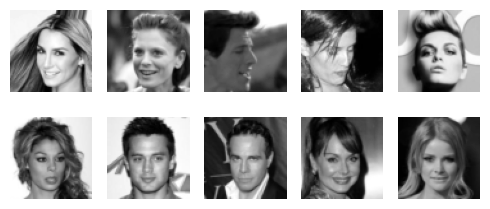

In [7]:
# show the image
fig, ax = plt.subplots(2, 5, figsize=(5,2.5))
ax = ax.flatten()
for i, img in enumerate(x_initial):
    ax[i].imshow(img.squeeze(), cmap='gray')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

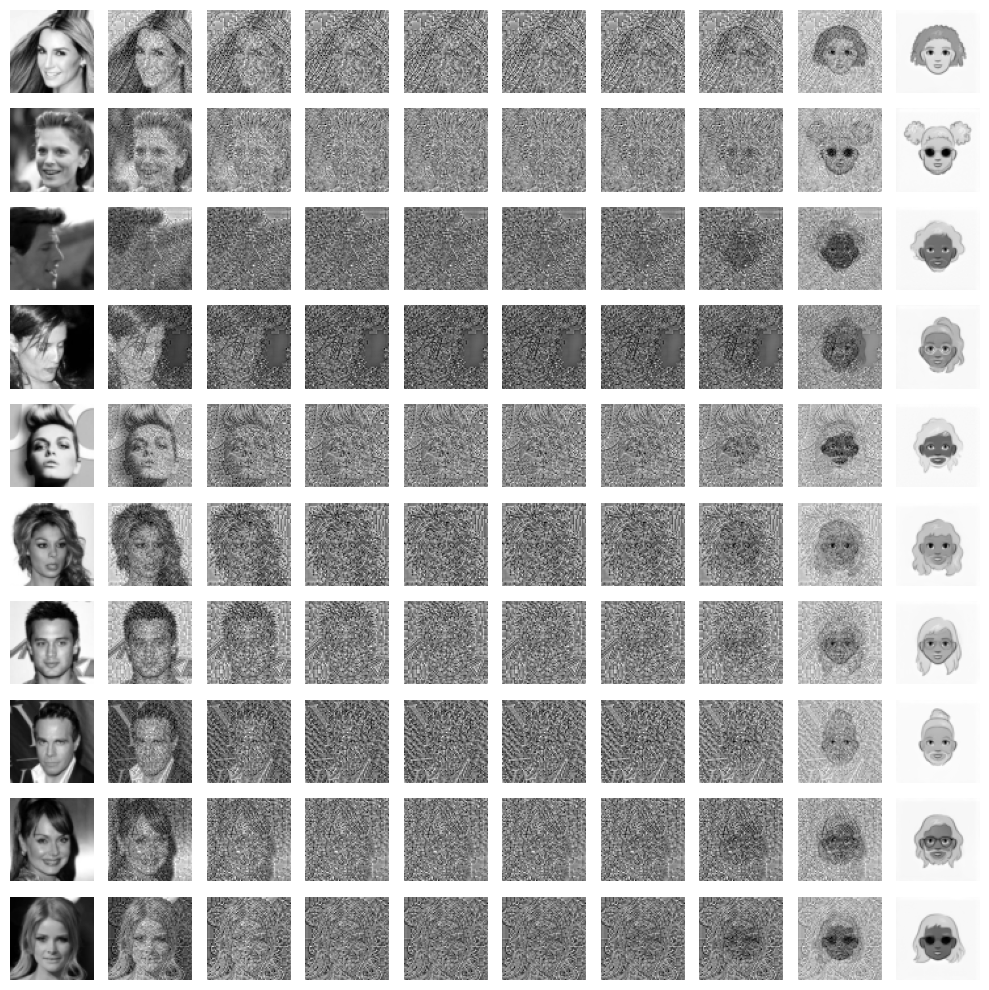

In [10]:
device = 'cpu'

model_counter = ut.model_counter(model)
# x_initial = next(iter(combined_dataloader))[0][:10].to(device)

n_eval = 10
n_samples = 10
# x_initial = torch.randn(n_samples, 1, 28, 28)

t = torch.linspace(0,1., n_eval)
inital_batch_size = x_initial.shape[0]

if n_samples > inital_batch_size:
    # if x_initial has less samples than n_samples, repeat x_initial at random to get n_samples
    n_new_samples = n_samples - inital_batch_size
    x_initial = torch.cat([x_initial, x_initial[torch.randint(0, inital_batch_size, (n_new_samples,))]], dim=0)
if n_samples < inital_batch_size:
    # if x_initial has more samples than n_samples, randomly choose n_samples samples from x_initial
    x_initial = x_initial[torch.randperm(inital_batch_size)[:n_samples]]


method = 'dopri5'
rtol = 1e-4
atol = 1e-4
out = odeint(model_counter, x_initial, t, method=method, rtol=rtol, atol=atol)

# show the image
fig, axs = plt.subplots(n_samples, n_eval, figsize=(n_eval, n_samples))

for i in range(n_samples):
    for j in range(n_eval):
        axs[i, j].imshow(out[j][i].squeeze().detach().numpy(), cmap='gray')
        axs[i, j].axis('off')
    
plt.tight_layout()
plt.show()


In [14]:
cartoon = ut.cartoon_dataset()

# 

In [18]:
x_initial_cartoon = []
for i, [img, _] in enumerate(cartoon):
    if i == 10:
        break
    else:
        x_initial_cartoon.append(img)

x_initial_cartoon = torch.cat(x_initial_cartoon, dim=0).unsqueeze(1)

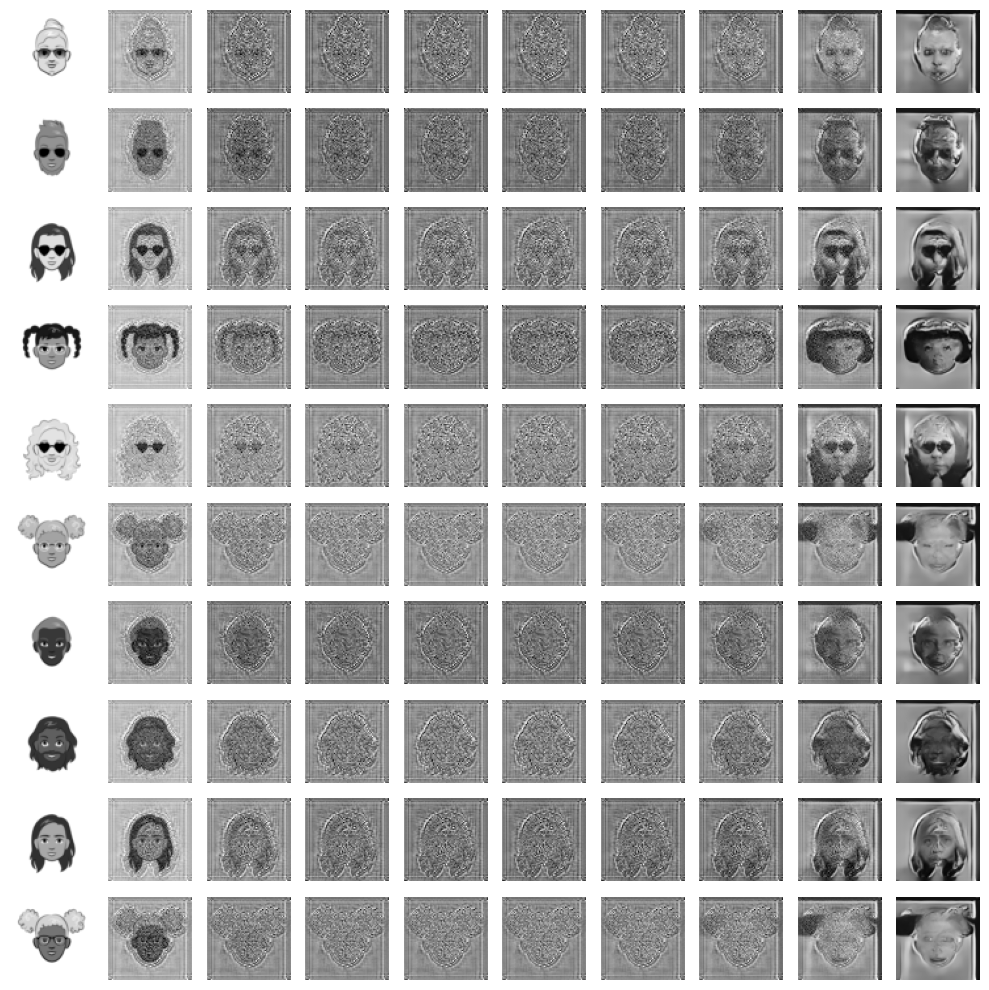

In [19]:

# x_initial = next(iter(combined_dataloader))[1][:10].to(device)
# x_initial = torch.randn(10, 1, 28, 28).to(device)

# reverse_model = rvrs_model(model)

n_eval = 10
n_samples = 10
# x_initial = torch.randn(n_samples, 1, 28, 28)

t = torch.linspace(1,-0., n_eval,)
inital_batch_size = x_initial_cartoon.shape[0]

if n_samples > inital_batch_size:
    # if x_initial has less samples than n_samples, repeat x_initial at random to get n_samples
    n_new_samples = n_samples - inital_batch_size
    x_initial_cartoon = torch.cat([x_initial_cartoon, x_initial_cartoon[torch.randint(0, inital_batch_size, (n_new_samples,))]], dim=0)
if n_samples < inital_batch_size:
    # if x_initial has more samples than n_samples, randomly choose n_samples samples from x_initial
    x_initial_cartoon = x_initial_cartoon[torch.randperm(inital_batch_size)[:n_samples]]


method = 'dopri5'
rtol = 1e-4
atol = 1e-4
out = odeint(model, x_initial_cartoon, t, method=method, rtol=rtol, atol=atol)

# show the image
fig, axs = plt.subplots(n_samples, n_eval, figsize=(n_eval, n_samples))

for i in range(n_samples):
    for j in range(n_eval):
        axs[i, j].imshow(out[j][i].squeeze().detach().numpy(), cmap='gray')
        axs[i, j].axis('off')
    
plt.tight_layout()
plt.show()

In [15]:
from sklearn.neighbors import NearestNeighbors


def get_nearest_neighbors(x, x_train, n_neighbors=5):
    print(x.shape, x_train.shape)
    x = x.reshape(x.shape[0], -1)
    x_train = x_train.reshape(x_train.shape[0], -1)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(x_train)
    distances, indices = nbrs.kneighbors(x)
    return indices

cartoon_dataset = []
for i, [img, _] in tqdm(enumerate(cartoon)):
    assert img.shape == (1, 64, 64)
    cartoon_dataset.append(img.numpy())

cartoon_dataset = np.array(cartoon_dataset)




10000it [00:46, 216.18it/s]


In [16]:
gen_samples = out[-1].detach().cpu()

x0_closest = get_nearest_neighbors(gen_samples, cartoon_dataset, n_neighbors=1)

torch.Size([10, 1, 64, 64]) (10000, 1, 64, 64)


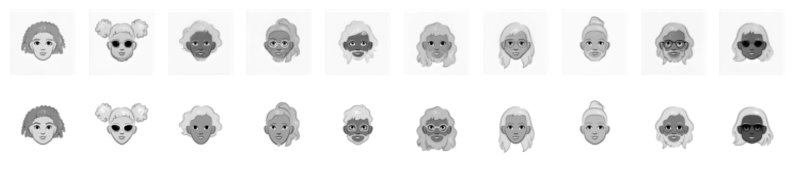

In [17]:
fig, axs = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    axs[0, i].imshow(gen_samples[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(cartoon_dataset[x0_closest[i][0]].squeeze(), cmap='gray')
    axs[1, i].axis('off')